In [21]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.metrics import accuracy_score
from sklearn import linear_model

In [16]:
raw = yf.download('GLD', start='2010-01-04', end='2019-12-31')
data = raw[['Adj Close']]
data.rename(columns={'Adj Close':'price'}, inplace=True)
data['log_returns'] = (data['price'].pct_change() + 1).apply(np.log)
data.dropna(inplace=True)

# create lag features
lags = 3
cols = []
for i in range(1,lags + 1):
    col = f"lag_{i}"
    data[col] = data['log_returns'].shift(i)
    cols.append(col)
data.dropna(inplace=True)
data.head() 

lm = linear_model.LogisticRegression(C=1e7, solver='lbfgs', multi_class='auto', max_iter=1000)
lm.fit(data[cols],np.sign(data['log_returns']))
data['prediction'] = lm.predict(data[cols])

hits = np.sign(data['prediction'][lags:] * data['log_returns'][lags:]).value_counts()
hits

[*********************100%***********************]  1 of 1 completed


C:\Users\Eddie\anaconda3\envs\securities-analysis\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Eddie\AppData\Local\Temp/ipykernel_7544/966003306.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_returns'] = (data['price'].pct_change() + 1).apply(np.log)
C:\Users\Eddie\anaconda3\envs\securities-analysis\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentat

 1.0    1335
-1.0    1161
 0.0      12
dtype: int64

C:\Users\Eddie\AppData\Local\Temp/ipykernel_7544/4016494423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['strategy'] = data['prediction'] * data['log_returns']


<AxesSubplot:xlabel='Date'>

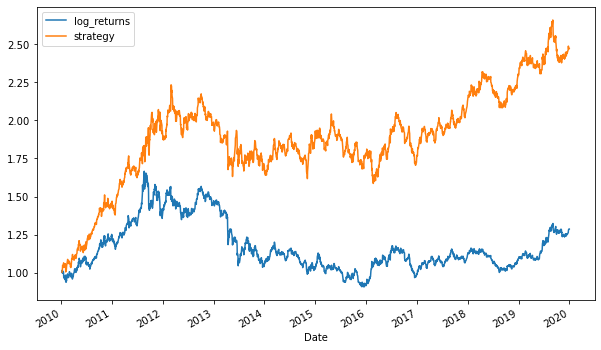

In [18]:
accuracy_score(data['prediction'], np.sign(data['log_returns']))
data['strategy'] = data['prediction'] * data['log_returns']
data[['log_returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

In [29]:
class ScikitVectorBacktester(object):
    ''' Class for the vectorized backtesting of
    Machine Learning-based trading strategies.
    Attributes
    ==========
    symbol: str
        TR RIC (financial instrument) to work with
    start: str
        start date for data selection
    end: str
        end date for data selection
    amount: int, float
        amount to be invested at the beginning
    tc: float
        proportional transaction costs (e.g. 0.5% = 0.005) per trade
    model: str
        either 'regression' or 'logistic'
    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    select_data:
        selects a sub-set of the data
    prepare_features:
        prepares the features data for the model fitting
    fit_model:
        implements the fitting step
    run_strategy:
        runs the backtest for the regression-based strategy
    plot_results:
        plots the performance of the strategy compared to the symbol
    '''

    def __init__(self, symbol, start, end, amount, tc, model):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.amount = amount
        self.tc = tc
        self.results = None
        if model == 'regression':
            self.model = linear_model.LinearRegression()
        elif model == 'logistic':
            self.model = linear_model.LogisticRegression(C=1e6,
                solver='lbfgs', multi_class='ovr', max_iter=1000)
        else:
            raise ValueError('Model not known or not yet implemented.')
        self.get_data()

    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        #raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
        #                  index_col=0, parse_dates=True).dropna()
        #raw = pd.DataFrame(raw[self.symbol])
        #raw = raw.loc[self.start:self.end]
        raw = yf.download(self.symbol, start=self.start, end=self.end)
        raw = raw[['Adj Close']]
        raw.rename(columns={'Adj Close': 'price'}, inplace=True)
        raw['returns'] = np.log(raw / raw.shift(1))
        self.data = raw.dropna()

    def select_data(self, start, end):
        ''' Selects sub-sets of the financial data.
        '''
        data = self.data[(self.data.index >= start) &
                         (self.data.index <= end)].copy()
        return data

    def prepare_features(self, start, end):
        ''' Prepares the feature columns for the regression and prediction steps.
        '''
        self.data_subset = self.select_data(start, end)
        self.feature_columns = []
        for lag in range(1, self.lags + 1):
            col = 'lag_{}'.format(lag)
            self.data_subset[col] = self.data_subset['returns'].shift(lag)
            self.feature_columns.append(col)
        self.data_subset.dropna(inplace=True)

    def fit_model(self, start, end):
        ''' Implements the fitting step.
        '''
        self.prepare_features(start, end)
        self.model.fit(self.data_subset[self.feature_columns],
                       np.sign(self.data_subset['returns']))

    def run_strategy(self, start_in, end_in, start_out, end_out, lags=3):
        ''' Backtests the trading strategy.
        '''
        self.lags = lags
        self.fit_model(start_in, end_in)
        # data = self.select_data(start_out, end_out)
        self.prepare_features(start_out, end_out)
        prediction = self.model.predict(
            self.data_subset[self.feature_columns])
        self.data_subset['prediction'] = prediction
        self.data_subset['strategy'] = (self.data_subset['prediction'] *
                                        self.data_subset['returns'])
        # determine when a trade takes place
        trades = self.data_subset['prediction'].diff().fillna(0) != 0
        # subtract transaction costs from return when trade takes place
        self.data_subset['strategy'][trades] -= self.tc
        self.data_subset['creturns'] = (self.amount *
                        self.data_subset['returns'].cumsum().apply(np.exp))
        self.data_subset['cstrategy'] = (self.amount *
                        self.data_subset['strategy'].cumsum().apply(np.exp))
        self.results = self.data_subset
        # absolute performance of the strategy
        aperf = self.results['cstrategy'].iloc[-1]
        # out-/underperformance of strategy
        operf = aperf - self.results['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)

    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to the symbol.
        '''
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        title = '%s | TC = %.4f' % (self.symbol, self.tc)
        self.results[['creturns', 'cstrategy']].plot(title=title,
                                                     figsize=(10, 6))

In [32]:
scibt = ScikitVectorBacktester('EURUSD=X','2010-01-01', '2019-12-31',10000, 0.0, 'logistic')
scibt.run_strategy('2015-01-01', '2019-12-31','2015-01-01', '2019-12-31', lags=15)

[*********************100%***********************]  1 of 1 completed


C:\Users\Eddie\anaconda3\envs\securities-analysis\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Eddie\AppData\Local\Temp/ipykernel_7544/2314747219.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['returns'] = np.log(raw / raw.shift(1))


(14472.9, 4771.37)

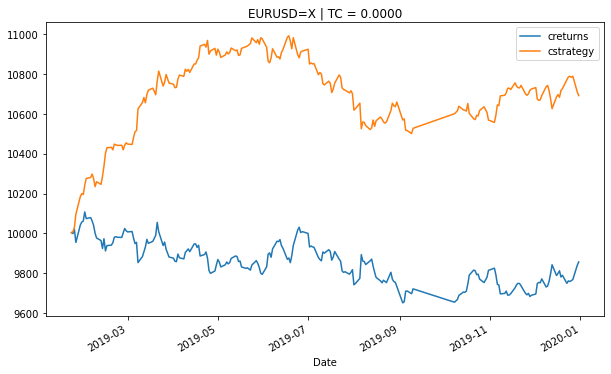

In [33]:
scibt.run_strategy('2016-1-1', '2018-12-31','2019-1-1', '2019-12-31', lags=15)
scibt.plot_results()

In [39]:
scibt = ScikitVectorBacktester('GDX','2010-1-1', '2019-12-31',10000, 0.00, 'logistic')

scibt.run_strategy('2013-01-01', '2017-12-31','2018-01-01', '2018-12-31', lags=10)

[*********************100%***********************]  1 of 1 completed


C:\Users\Eddie\anaconda3\envs\securities-analysis\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Eddie\AppData\Local\Temp/ipykernel_7544/2314747219.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['returns'] = np.log(raw / raw.shift(1))


(12809.62, 4109.75)

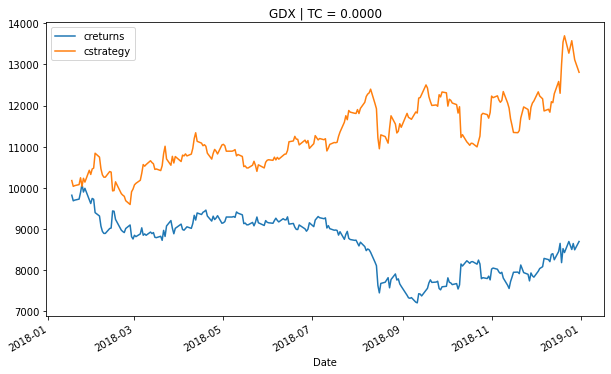

In [38]:
scibt.plot_results()